## Plotting the subsidence along the two CSET Lagrangian case studies

Here we're looking at the lower FT subsidence along CSET trajectories for two cases. RF06A, resampled on RF07BCDE (lots of divergence!), experienced a 'classic' transition in cloudiness, along with significant deepening and a strong LTS decrease (23C-18C). In contrast, RF10A, resampled on RF11DE (less divergence), while also experince a comparable LTS decrease (21C-16C), was in a region of less subsidence

In [1]:
import datetime as dt
import numpy as np
import os
import xarray as xr
import utils
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12,5
import matplotlib.pyplot as plt
import glob
import pandas as pd
from utils import read_tdump
from itertools import cycle
%load_ext autoreload
%autoreload 2

In [5]:
#TODO: the better way to load these would be to look at which
#      trajectories start during e.g. "RF10A", but for now...
case_1_trajectories = {'flight': 'rf06', 
                       'trajs': ['2.3', '2.6', '3.0', '3.5']}#, '4.0', '4.3', '4.6', '5.0']}
case_2_trajectories = {'flight': 'rf10', 
                       'trajs': ['5.0', '5.5', '6.0']}

for case in [case_1_trajectories, case_2_trajectories]:
    t_data = []
    for num in case['trajs']:
        tdump = utils.load_flight_trajectory(case['flight'], float(num))
        ds = xr.Dataset.from_dataframe(tdump)
        lats, lons, times = ds.lat.values, ds.lon.values, ds.dtime.values
        pressures = np.full_like(lats, fill_value=700)
        
        # adding ERA
        var_list = ['w', 'r']
        ERA_ds = utils.get_ERA_data(var_list=var_list, lats=lats, lons=lons, times=times,
                                   pressures=pressures, box_degrees=2)
        ds = xr.merge([ds, ERA_ds.rename({'w': 'ERA_w', 'r': 'ERA_RH', 'time': 'dtime'})])
        
        #adding MERRA
        var_list = ['SO4', 'RH']
        MERRA_ds = utils.get_MERRA_data(var_list=var_list, lats=lats, lons=lons, times=times,
                                   pressures=pressures, box_degrees=2)
        ds = xr.merge([ds, MERRA_ds.rename({'RH': 'MERRA_RH', 'SO4': 'MERRA_SO4', 'time': 'dtime'})])
        t_data.append(ds)
        
        print('done with {} {}'.format(case['flight'], num))
    case['data'] = t_data
        

done with rf06 2.3
done with rf06 2.6
done with rf06 3.0
done with rf06 3.5
done with rf10 5.0
done with rf10 5.5
done with rf10 6.0


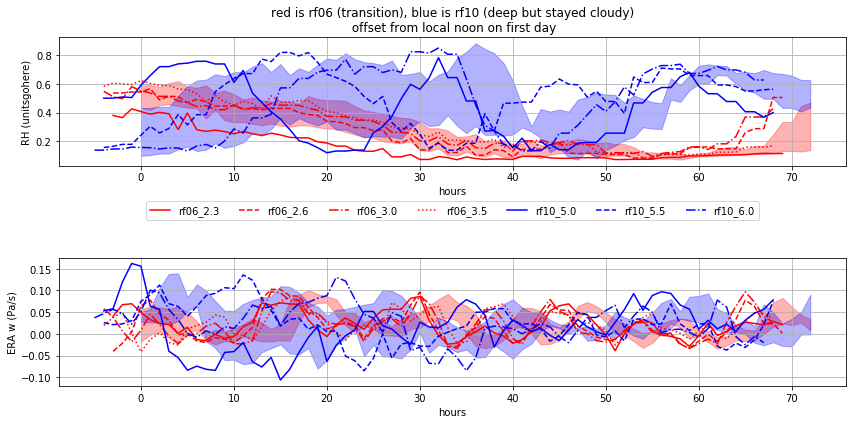

In [6]:
fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(12,6))
def add_traj_to_plot(variable, tdata, plot_dict, ax):
    start_hour = utils.as_datetime(tdata.dtime.values[0]).hour
    offset = start_hour-21
    ax.plot(np.arange(len(tdata.dtime))+offset, tdata[variable], **plot_dict)
    return offset

lines = ["-","--","-.",":"]

for case, col in zip([case_1_trajectories, case_2_trajectories], ['r', 'b']):
    ERA_w_to_mean = []
    MERRA_to_mean = []
    linecycler = cycle(lines)
    for (tname, tdata) in zip(case['trajs'], case['data']): 
        plot_dict = {"color": col, 
                     "ls": next(linecycler),
                     "label": case['flight'] + "_" + tname}
        m_off = add_traj_to_plot(variable='MERRA_RH', tdata=tdata, plot_dict=plot_dict, ax=ax1)
        e_off = add_traj_to_plot(variable='ERA_w', tdata=tdata, plot_dict=plot_dict, ax=ax2)
        MERRA_to_mean.append(tdata['MERRA_RH'].values)
        ERA_w_to_mean.append(tdata['ERA_w'].values)

    MERRA_mean = np.array(MERRA_to_mean).mean(axis=0)
    MERRA_std = np.array(MERRA_to_mean).std(axis=0)
    ERA_mean = np.array(ERA_w_to_mean).mean(axis=0)
    ERA_std = np.array(ERA_w_to_mean).std(axis=0)

    ax1.fill_between(np.arange(len(MERRA_mean)), MERRA_mean+MERRA_std, MERRA_mean-MERRA_std, color=col, alpha=0.3)
    ax2.fill_between(np.arange(len(ERA_mean)), ERA_mean+ERA_std, ERA_mean-ERA_std, color=col, alpha=0.3)

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=len(ax1.lines), borderaxespad=1)
ax1.set_title('red is rf06 (transition), blue is rf10 (deep but stayed cloudy)'+
            '\n offset from local noon on first day')
ax1.set_ylabel('RH (unitsgohere)')
ax1.set_xlabel('hours')
ax1.grid()

ax2.set_ylabel('ERA w (Pa/s)')
ax2.set_xlabel('hours')
ax2.grid()

fig.tight_layout(h_pad=3)
## TODO shift it so that day/night is consistent between them




So it looks like RF06A has consistent 700hpa subsidence of ~0.05 Pa/s, which using hydrostatic eqn is ~0.005m/s, or 5mm/s, which is what we expect. RF10A has highly variable subsidence along the sequence, with the 700hpa vertical wind of the southwestermost trajectory (5.0) actually being upward. General consistent subsidence begins after about 44 hours only. 

RF06 700mb RH also clearly shows a drying FT, while RF10 again has lots of variability. this is consistent with the scattered midlevel cloud over RF10